### Nikita Puchkin and Valeriia Shcherbakova

### Numerical experiments on artificial and CENSREC-1-C data sets, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from sklearn.metrics.pairwise import pairwise_distances


# Set the thresholds as recorded in the files
# in the 'thresholds' folder

from consts import *


%matplotlib inline

### Online change point detection procedure (polynomials)

In [2]:
# Auxiliary function
# Computation of design matrix based on (1, x, x**2, ..., x**(p-1))
#
# X -- array of univariate observations
#
# p -- positive integer
#
def compute_design(X, p):
    
    n = X.shape[0]
    Psi = np.power(np.outer(X, np.ones(p)), np.outer(np.ones(n), np.arange(p)))
    # print(Psi.shape)
    
    return Psi

In [3]:
# Auxiliary function
# Computation of the best fitting parameter theta
# under the hypothesis that tau is the true change point
#
# Psi -- (n x p)-array, design matrix 
#
# tau -- change point candidate
#
def compute_theta(Psi, tau):
    
    # Sample size
    t = Psi.shape[0]
    
    # Create "virtual" labels
    Y = np.append(np.ones(tau), -np.ones(t - tau))
    
    lr = LogisticRegression(penalty='none', fit_intercept=False, tol=1e-2,\
                            solver='newton-cg', class_weight='balanced', n_jobs=-1)
    lr.fit(Psi, Y)
    theta = (lr.coef_).reshape(-1)
    
    return theta

In [4]:
# Computation of the test statistic
#
# X -- array of univariate observations
#
# p -- positive integer (used for basis construction)
#
def compute_test_stat_linear(X, p, t_min=20, n_out_min=10, B=10):
    
    # Sample size
    n = X.shape[0]
    
    # Compute design matrix
    Psi = compute_design(X, p)
    
    # Initialization
    T = np.zeros((n, n))
    
    for t in range(t_min, n):
        
        D = np.zeros(t)
        
        for tau in range(n_out_min, t-n_out_min):
            
            # Compute the best fitting parameter theta
            theta = compute_theta(Psi[:t, :], tau)
            Z = Psi[:t, :] @ theta
            
            # Use thresholding to avoid numerical issues
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            # Compute statistics for each t
            # and each change point candidate tau
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
            
    # Array of test statistics
    S = np.max(T, axis=0)
    
    return S

### Online change point detection procedure (Fourier basis)

In [5]:
def compute_design_Fourier(X, p):
    res = np.zeros((p, X.shape[0]))
    res[0] = np.ones(X.shape[0]) / np.sqrt(2)
    T = 1
    for i in range(1, p):
        if (i // 2 == 0):
            res[i] = np.sin(X * 2 * np.pi * i / T) / np.sqrt(T / 2)
        else:
            res[i] = np.cos(X * (2 * np.pi * i) / T) / np.sqrt(T / 2)
    return res.T

In [6]:
# Computation of the test statistic
#
# X -- array of univariate observations
#
# p -- positive integer (used for basis construction)
#
def compute_test_stat_fourier(X, p, t_min=20, n_out_min=10, B=10):
    
    # Sample size
    n = X.shape[0]
    
    # Compute design matrix
    Psi = compute_design_Fourier(X, p)
    
    # Initialization
    T = np.zeros((n, n))
    
    for t in range(t_min, n):
        
        D = np.zeros(t)
        
        for tau in range(n_out_min, t-n_out_min):
            
            # Compute the best fitting parameter theta
            theta = compute_theta(Psi[:t, :], tau)
            Z = Psi[:t, :] @ theta
            
            # Use thresholding to avoid numerical issues
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            # Compute statistics for each t
            # and each change point candidate tau
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
            
    # Array of test statistics
    S = np.max(T, axis=0)
    
    return S

### Online change point detection procedure (neural networks)

In [7]:
class NN(nn.Module):
    def __init__(self, n_in, n_out):
        
        super(NN, self).__init__()
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(n_in, 2 * n_in)
        self.fc2 = nn.Linear(2 * n_in, 3 * n_in)
        self.fc3 = nn.Linear(3 * n_in, n_out)        
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        
        return x

In [8]:
# Computation of the test statistic
#
# X -- array of univariate observations
#
# p -- positive integer (used for basis construction)
#
def compute_test_stat_nn(X, t_min=20, n_out_min=10, B=10, n_epochs=200, model=NN):
    
    X = X.reshape(-1, 1)
    
    # Sample size
    n = X.shape[0]
    
    # Initialization
    T = np.zeros((n, n))
    
    for t in range(t_min, n):
    
        for tau in range(n_out_min, t-n_out_min):
            
            # Initialize neural network
            f = model(n_in=1, n_out=1)
            
            # Parameters of the optimizer
            opt = torch.optim.Adam(f.parameters(), lr=1e-1)
            
            X_t = torch.tensor(X[:t, :], dtype=torch.float32, requires_grad=True)
            
            # weights
            W = torch.cat((torch.ones(tau) * (t - tau), torch.ones(t - tau) * tau)).reshape(-1, 1)
            
            # Create "virtual" labels
            Y_t = torch.cat((torch.ones(tau), torch.zeros(t - tau))).reshape(-1, 1)
    
            # Loss function    
            loss_fn = nn.BCEWithLogitsLoss(weight=W)
            
            # Neural network training
            for epoch in range(n_epochs):
                
                loss = loss_fn(f(X_t), Y_t).mean()
                loss.backward()
                opt.step()
                opt.zero_grad()
                
            Z = f(X_t).detach().numpy().reshape(-1)
            
            # Use thresholding to avoid numerical issues
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D = np.zeros(t)
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            # Compute statistics for each t
            # and each change point candidate tau
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
       
    # Array of test statistics
    S = np.max(T, axis=0)
    
    return S

### KLIEP online change point procedure (Sugiyama et al. (2008), Liu et al. (2013))

In [9]:
def compute_test_stat_kliep(X, window_size=10, sigma=0.1):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    # More convenient notation
    b = window_size
    
    # Sample size
    n = X.shape[0]
    
    # Initialization
    T = np.zeros(n)
    
    for t in range(2*b + 1, n):
        
        # Test sample
        X_te = X[t-b:t]
        # Reference sample
        X_re = X[t-2*b:t-b]
        
        T[t] = kliep(X_te, X_re, sigma)
    
    return T

In [10]:
def kliep(X_te, X_re, sigma):
    
    # Test sample size
    n_te = X_te.shape[0]
    # Reference sample size
    n_re = X_re.shape[0]
    
    # Compute pairwise distances
    te_te_dist = pairwise_distances(X_te)
    re_te_dist = pairwise_distances(X_re, X_te)
    
    # Compute kernel matrices
    te_te_kernel = np.exp(-0.5 * (te_te_dist / sigma)**2)
    re_te_kernel = np.exp(-0.5 * (re_te_dist / sigma)**2)
    
    # Initialize a vector of coefficients
    theta = cvx.Variable(n_te)
    
    # Objective
    obj = cvx.Maximize(cvx.sum(cvx.log(te_te_kernel @ theta)))
    
    # Constraints
    constraints = [cvx.sum(re_te_kernel @ theta) == n_re, theta >= 0]
    
    # Problem
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    
    return obj.value

### An online change point detection procedure based on M-statistic (Li, Xie, Dai and Song (2015))

In [11]:
# Compute MMD test statistic
def compute_test_stat_mmd(X, window_size=10, sigma=0.1):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    # More convenient notation
    b = window_size
    
    # Sample size
    n = X.shape[0]
    
    # Initialization
    T = np.zeros(n)
    
    for t in range(2*b + 1, n):
        
        # Test sample
        X_te = X[t-b:t, :]
        # Reference sample
        X_re = X[t-2*b:t-b, :]
        
        MMD_2 = mmd_squared(X_re, X_te, sigma)
        var = estimate_variance(X_re, window_size, sigma)
        
        T[t] = MMD_2 / np.sqrt(var)
    
    return T

In [12]:
def mmd_squared(X, Y, sigma):
    
    # Sample size
    n = X.shape[0]
    
    # Compute pairwise distances
    xx_dist = pairwise_distances(X)
    xy_dist = pairwise_distances(X, Y)
    yy_dist = pairwise_distances(Y)
    
    # Compute kernel matrices
    xx_kernel = np.exp(-0.5 * (xx_dist / sigma)**2) - np.identity(n)
    xy_kernel = np.exp(-0.5 * (xy_dist / sigma)**2) - np.identity(n)
    yy_kernel = np.exp(-0.5 * (yy_dist / sigma)**2) - np.identity(n)
    
    # Compute the U-statistic
    u_stat = (np.sum(xx_kernel) - 2 * np.sum(xy_kernel) + np.sum(yy_kernel)) / n / (n - 1)
    
    return u_stat

In [13]:
def h_squared(X, sigma):
    
    # Sample size
    n = X.shape[0]
    
    # Divide the array into four equal parts
    n_max = 4 * (n // 4)
    X_1 = X[0:n_max:4]
    X_2 = X[1:n_max:4]
    X_3 = X[2:n_max:4]
    X_4 = X[3:n_max:4]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    return np.mean((K_12 - K_13 - K_24 + K_34)**2)


# Compute the first term in the variance estimate
def h_cov(X, sigma):
    
    # Sample size
    n = X.shape[0]
    
    # Divide the array into six equal parts
    n_max = 6 * (n // 6)
    X_1 = X[0:n_max:6]
    X_2 = X[1:n_max:6]
    X_3 = X[2:n_max:6]
    X_4 = X[3:n_max:6]
    X_5 = X[4:n_max:6]
    X_6 = X[5:n_max:6]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    K_56 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_6, axis=1) / sigma)**2)
    K_53 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_3, axis=1) / sigma)**2)
    K_64 = np.exp(-0.5 * (np.linalg.norm(X_6 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    # Compute the second term in the variance estimate
    h_1234 = K_12 - K_13 - K_24 + K_34
    h_5634 = K_56 - K_53 - K_64 + K_34
    
    return np.mean((h_1234 - np.mean(h_1234)) * (h_5634 - np.mean(h_5634)))

# Variance estimate under the null hypothesis
def estimate_variance(X, window_size, sigma):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
        
    # Sample size
    n = X.shape[0]
    
    # Compute the first term in the variance estimate
    h2 = h_squared(X, sigma) 
    
    # Compute the second term in the variance estimate
    h_c = h_cov(X, sigma)
    
    # Variance estimate
    var = 2 * (h2 + h_c) / window_size / (window_size - 1)
        
    return np.maximum(var, 1e-5)

### CUSUM

In [14]:
def compute_cusum(X):
    T = np.zeros(X.shape[0])
    for n in range(1, X.shape[0]):
        t = np.zeros(n)
        for k in range(1, n):

            t[k] = abs((n - k) * X[:k].sum()   - k * X[k:n].sum() ) / np.sqrt(n * k * (n - k))
          # t = abs(np.mean(X[:k]) - np.mean(X[k:n]))
        T[n] = np.max(t)
    return T

In [15]:
def compute_cusum_squared(X):
    T = np.zeros(X.shape[0])
    for n in range(1, X.shape[0]):
        t = np.zeros(n)
        for k in range(1, n):

            t[k] = abs((n - k) * np.power(X[:k], 2).sum()   - k * np.power(X[k:n], 2).sum() ) / np.sqrt(n * k * (n - k))
          # t = abs(np.mean(X[:k]) - np.mean(X[k:n]))
        T[n] = np.max(t)
    return T

### Illustration: stationary regime vs. change point

In [30]:
np.random.seed(1)

# Number of observations
n = 100
# True change point
tau = 75

# Shift size
mu = 0.2

# Standard deviation of the observations
sigma = 0.1

# X denotes a sequence of i.i.d. observations,
# while Y corresponds to a sequence with a change point

# Generate Gaussian sequences of observations
X = sigma * randn(n)
Y = np.copy(X)

# Add a shift to the second half of Y's
Y[tau:] += mu

In [31]:
# Apply the change point detection procedure
S_X = compute_test_stat_linear(X, p=2)
S_Y = compute_test_stat_linear(Y, p=2)

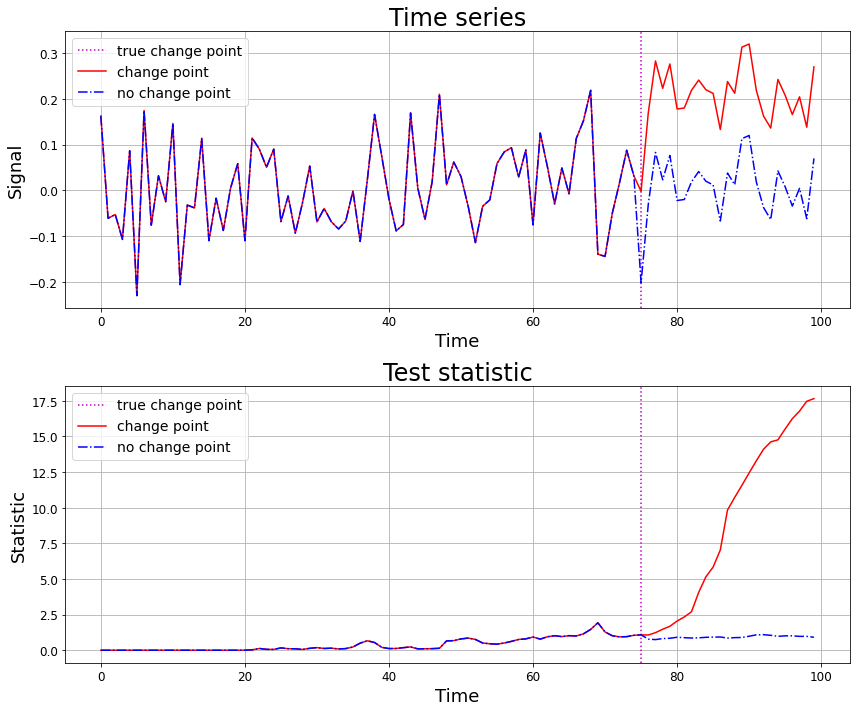

In [33]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.axvline(tau, c='m', ls=':', label='true change point')
plt.plot(Y, 'r', label='change point')
plt.plot(X, 'b-.', label='no change point')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title(label='Time series', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()


plt.subplot(2, 1, 2)
plt.title(label='Test statistic', fontsize=24)

plt.axvline(tau, c='m', ls=':', label='true change point')

plt.plot(np.arange(n), S_Y, 'r-', label='change point')
plt.plot(np.arange(n), S_X, 'b-.', label='no change point')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Statistic', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('images/illustration.png')

### Mean shift detection

In [ ]:
np.random.seed(1)

# Number of observations
n = 150
# True change point
tau = 75

# Shift size
mu = 0.2

# Standard deviation of the observations
sigma = 0.1

# Generate a Gaussian sequence of observations
X = sigma * randn(n)
X = sigma * randn(n)
X = sigma * randn(n)
X[tau:] += mu

In [ ]:
S_cusum = compute_cusum(X)

In [ ]:
# Apply the change point detection procedure
p = 2
S_lin = compute_test_stat_linear(X, p)
S_nn = compute_test_stat_nn(X, n_epochs=50)
S_f = compute_test_stat_fourier(X, p)

In [ ]:
S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.2)

In [ ]:
S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.5)  

In [ ]:
S_mmd_norm = S_mmd / 4
threshold_mmd_norm = threshold_mmd_50 / 4

In [ ]:
S_cusum = compute_cusum(X)  

In [ ]:
S_cusum_norm = S_cusum * 10
threshold_cusum_norm = threshold_cusum * 10

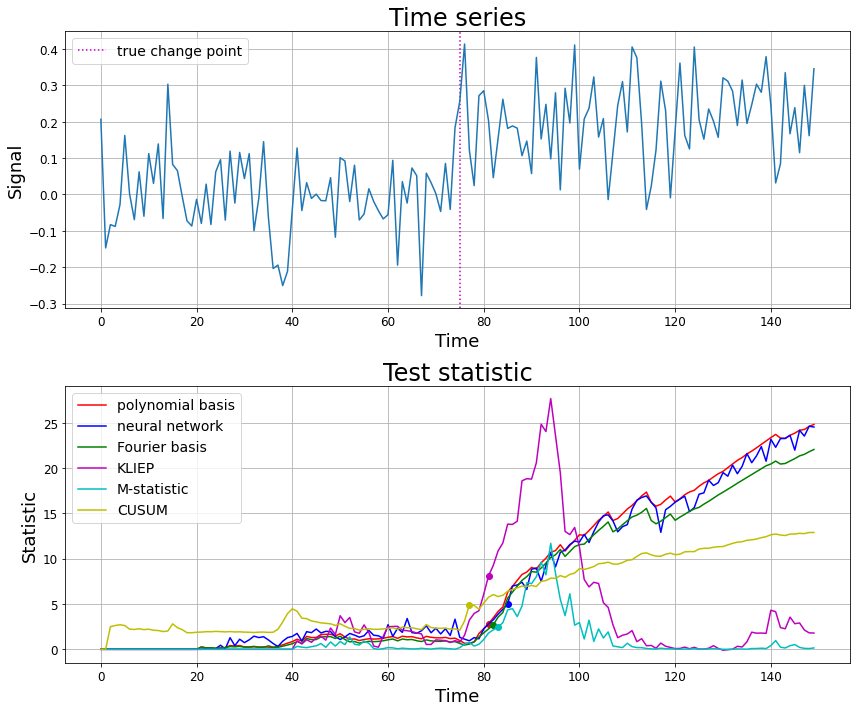

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.axvline(tau, c='m', ls=':', label='true change point')
plt.plot(X)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title(label='Time series', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.subplot(2, 1, 2)
# plt.plot([tau], S_lin[tau], 'x',c='m', label='True change point')
# plt.axhline(y=threshold_nn, xmin=0, xmax=70, ls='--', c='r',label='theshold')
plt.title(label='Test statistic', fontsize=24)
imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_2_poly))
imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_p_2_f))
imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <=  threshold_kliep_20))
imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd_norm, S_mmd_norm <= threshold_mmd_norm))
imin_cusum, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_cusum_norm, S_cusum_norm <= threshold_cusum_norm))

# plt.axvline(tau, c='m', ls=':', label='true change point')

plt.plot([imin_lin], S_lin[imin_lin], 'o', c='r')
plt.plot([imin_nn], S_nn[imin_nn], 'o', c='b')
plt.plot([imin_f], S_f[imin_f], 'o', c='g')
plt.plot([imin_kliep], S_kliep[imin_kliep], 'o', c='m')
plt.plot([imin_mmd], S_mmd_norm[imin_mmd], 'o', c='c')
plt.plot([imin_cusum], S_cusum_norm[imin_cusum], 'o', c='y')
    
plt.plot(np.arange(n), S_lin, 'r-', label='polynomial basis')
plt.plot(np.arange(n), S_nn, 'b-', label='neural network')
plt.plot(np.arange(n), S_f, 'g-', label='Fourier basis')
plt.plot(np.arange(n), S_kliep, 'm-', label='KLIEP')
plt.plot(np.arange(n), S_mmd_norm, 'c-', label='M-statistic')
plt.plot(np.arange(n), S_cusum_norm, 'y-', label='CUSUM')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Statistic', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('images/dataset1.png')

In [ ]:
np.random.seed(1)

# Number of observations
n = 150
# True change point
tau = 75

# Shift size
mu = 0.2

# Standard deviation of the observations
sigma = 0.1

p = 2
S_poly_list = []
S_nn_list = []
S_f_list = [] 

S_cusum_list = []

for item in range(10):
    # Generate a Gaussian sequence of observations

    X = sigma * randn(n)
    X[tau:] += mu

    S_poly = compute_test_stat_linear(X, p)
    S_nn = compute_test_stat_nn(X, n_epochs=50)
    S_f = compute_test_stat_fourier(X, p)

    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)
    S_f_list.append(S_f)
    
    
    S_cusum = compute_cusum(X)
    
    S_cusum_list.append(S_cusum)

In [ ]:
import pandas as pd

In [ ]:
S_cusum_np = np.array(S_cusum_list)
df = pd.DataFrame(S_cusum_np.T, columns=range(10))
df.to_csv('DD/dataset_1_cusum.csv',index=False)

In [ ]:
S_nn_np = np.array(S_nn_list)
df_nn = pd.DataFrame(S_nn_np.T, columns=range(10))
df_nn.to_csv('DD/dataset_1_nn.csv',index=False)

In [ ]:
S_f_np = np.array(S_f_list)
df_f = pd.DataFrame(S_f_np.T, columns=range(10))
df_f.to_csv('DD/dataset_1_f.csv',index=False)

In [ ]:
S_poly_np = np.array(S_poly_list)
df_poly = pd.DataFrame(S_poly_np.T, columns=range(10))
df_poly.to_csv('DD/dataset_1_poly.csv',index=False)

In [ ]:
t_lin = []
t_nn = []
t_f= []
t_cusum = []
for i in range(10):

    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    S_f = S_f_list[i]
    S_cusum = S_cusum_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_2_poly))
    imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
    imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_p_2_f))
    imin_cusum, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_cusum, S_cusum <= threshold_cusum))

    t_lin.append(imin_lin - tau)
    t_nn.append(imin_nn - tau)
    t_f.append(imin_f - tau)
    t_cusum.append(imin_cusum - tau)

In [ ]:
t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np[t_lin_np>0].mean(), 1)
std_DD_poly = np.round(t_lin_np[t_lin_np>0].std(), 1)
print('polynomial basis', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np[t_nn_np>0].mean(), 1)
std_DD_nn = np.round(t_nn_np[t_nn_np>0].std(), 1)
print('neural network', DD_nn, '±', std_DD_nn)

t_f_np = np.array(t_f)
DD_f = np.round(t_f_np[t_f_np>0].mean(), 1)
std_DD_f = np.round(t_f_np[t_f_np>0].std(), 1)
print('Fourier basis', DD_f, '±', std_DD_f)

t_cusum_np = np.array(t_cusum)
DD_cusum = np.round(t_cusum_np[t_cusum_np>0].mean(), 1)
std_DD_cusum = np.round(t_cusum_np[t_cusum_np>0].std(), 1)
print('CUSUM', DD_cusum, '±', std_DD_cusum)

polynomial basis 6.7 ± 2.0
neural network 9.1 ± 1.4
Fourier basis 7.6 ± 2.1
CUSUM 5.0 ± 2.0


In [ ]:
np.random.seed(1)

# Number of observations
n = 150
# True change point
tau = 75

# Shift size
mu = 0.2

# Standard deviation of the observations
sigma = 0.1

S_kliep_list = []
S_mmd_list = []

for item in range(10):
    # Generate a Gaussian sequence of observations

    X = sigma * randn(n)
    X[tau:] += mu

    S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.2)
    S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)
    print(item)
    
t_kliep = []
t_mmd = []

for i in range(10):

    S_kliep = S_kliep_list[i]
    S_mmd = S_mmd_list[i]
    
    if np.sum(S_kliep > threshold_kliep_20) > 0:
            imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_20))
    else:
        imin_kliep = n
    
    if np.sum(S_mmd > threshold_mmd_50) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_50))
    else:
        imin_mmd = n
    
    t_kliep.append(imin_kliep - tau)
    t_mmd.append(imin_mmd - tau)
    
t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np[t_kliep_np>0].mean(), 1)
std_DD_kliep = np.round(t_kliep_np[t_kliep_np>0].std(), 1)
print('Kliep', DD_kliep, '±', std_DD_kliep)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np[t_mmd_np>0].mean(), 1)
std_DD_mmd = np.round(t_mmd_np[t_mmd_np>0].std(), 1)
print('M-stat', DD_mmd, '±', std_DD_mmd)

0
1
2
3
4
5
6
7
8
9
Kliep 9.0 ± 3.5
M-stat 10.4 ± 3.4


In [ ]:
S_kliep_np = np.array(S_kliep_list)
df = pd.DataFrame(S_kliep_np.T, columns=range(10))
df.to_csv('DD/dataset_1_kliep.csv',index=False)

In [ ]:
S_mmd_np = np.array(S_mmd_list)
df = pd.DataFrame(S_mmd_np.T, columns=range(10))
df.to_csv('DD/dataset_1_mmd.csv',index=False)

### Variance change detection

In [ ]:
# Number of observations
n = 150
# True change point
tau = 75

# Standard deviation before the change point
sigma_1 = 0.1
# Standard deviation after the change point
sigma_2 = 0.3

# Generate a Gaussian sequence of observations
np.random.seed(2)
X = randn(n)
X[:tau] *= sigma_1
X[tau:] *= sigma_2

In [ ]:
# Apply the change point detection procedure
p = 3
S_lin = compute_test_stat_linear(X, p)
S_nn = compute_test_stat_nn(X, n_epochs=50)
S_f = compute_test_stat_fourier(X, p)

In [ ]:
S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.33)
S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.1)    

In [ ]:
S_cusum = compute_cusum_squared(X)  

In [ ]:
S_mmd_norm = S_mmd / 4
threshold_mmd_norm = threshold_mmd_10 / 4

In [ ]:
S_cusum_norm = S_cusum * 10
threshold_cusum_norm = threshold_cusum_squared * 10

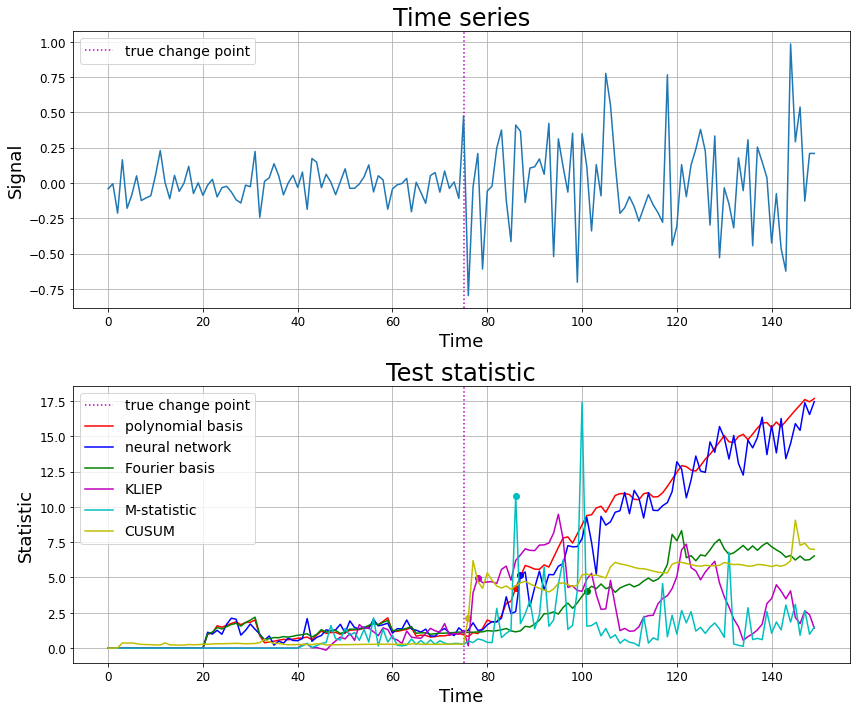

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.axvline(tau, c='m', ls=':', label='true change point')
plt.plot(X)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title(label='Time series', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.subplot(2, 1, 2)
# plt.plot([tau], S_lin[tau], 'x',c='m', label='True change point')
#plt.axhline(y=threshold_nn, xmin=0, xmax=70, ls='--', c='r',label='theshold')
plt.title(label='Test statistic', fontsize=24)
imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_3_poly))
imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_p_3_f))
imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <=  threshold_kliep_33))
imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd_norm, S_mmd_norm <= threshold_mmd_norm))
imin_cusum, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_cusum_norm, S_cusum_norm <= threshold_cusum_norm))

plt.axvline(tau, c='m', ls=':', label='true change point')

plt.plot([imin_lin], S_lin[imin_lin], 'o', c='r')
plt.plot([imin_nn], S_nn[imin_nn], 'o', c='b')
plt.plot([imin_f], S_f[imin_f], 'o', c='g')
plt.plot([imin_kliep], S_kliep[imin_kliep], 'o', c='m')
plt.plot([imin_mmd], S_mmd_norm[imin_mmd], 'o', c='c')
plt.plot([imin_cusum], S_cusum_norm[imin_cusum], 'o', c='y')
    
plt.plot(np.arange(n), S_lin, 'r-', label='polynomial basis')
plt.plot(np.arange(n), S_nn, 'b-', label='neural network')
plt.plot(np.arange(n), S_f, 'g-', label='Fourier basis')
plt.plot(np.arange(n), S_kliep, 'm-', label='KLIEP')
plt.plot(np.arange(n), S_mmd_norm, 'c-', label='M-statistic')
plt.plot(np.arange(n), S_cusum_norm, 'y-', label='CUSUM')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Statistic', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('images/dataset2.png')

In [ ]:
np.random.seed(1)

# Number of observations
n = 150
# True change point
tau = 75

# Standard deviation before the change point
sigma_1 = 0.1
# Standard deviation after the change point
sigma_2 = 0.3

p = 3
S_poly_list = []
S_nn_list = []
S_f_list = []

S_cusum_list = []

for item in range(10):
    # Generate a Gaussian sequence of observations

    X = randn(n)
    X[:tau] *= sigma_1
    X[tau:] *= sigma_2

    S_poly = compute_test_stat_linear(X, p)
    S_nn = compute_test_stat_nn(X, n_epochs=50)
    S_f = compute_test_stat_fourier(X, p)

    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)
    S_f_list.append(S_f)
    
    S_cusum = compute_cusum_squared(X)
    
    S_cusum_list.append(S_cusum)
    print(item)

0
1
2
3
4
5
6
7
8
9


In [ ]:
t_lin = []
t_nn = []
t_f= []
t_cusum = []
for i in range(10):

    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    S_f = S_f_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_3_poly))
    imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
    imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_p_3_f))
    
    imin_cusum, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_cusum, S_cusum <= threshold_cusum))

    t_lin.append(imin_lin - tau)
    t_nn.append(imin_nn - tau)
    t_f.append(imin_f - tau)
    t_cusum.append(imin_cusum - tau)

In [ ]:
t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np[t_lin_np>0].mean(), 1)
std_DD_poly = np.round(t_lin_np[t_lin_np>0].std(), 1)
print('polynomial basis', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np[t_nn_np>0].mean(), 1)
std_DD_nn = np.round(t_nn_np[t_nn_np>0].std(), 1)
print('neural network', DD_nn, '±', std_DD_nn)

t_f_np = np.array(t_f)
DD_f = np.round(t_f_np[t_f_np>0].mean(), 1)
std_DD_f = np.round(t_f_np[t_f_np>0].std(), 1)
print('Fourier basis', DD_f, '±', std_DD_f)

t_cusum_np = np.array(t_cusum)
DD_cusum = np.round(t_cusum_np[t_cusum_np>0].mean(), 1)
std_DD_cusum = np.round(t_cusum_np[t_cusum_np>0].std(), 1)
print('CUSUM', DD_cusum, '±', std_DD_cusum)

polynomial basis 16.4 ± 8.1
neural network 19.8 ± 8.4
Fourier basis 44.1 ± 16.8
CUSUM 39.0 ± 0.0


In [ ]:
S_nn_np = np.array(S_nn_list)
df_nn = pd.DataFrame(S_nn_np.T, columns=range(10))
df_nn.to_csv('DD/dataset_2_nn.csv',index=False)

In [ ]:
S_cusum_np = np.array(S_cusum_list)
df = pd.DataFrame(S_cusum_np.T, columns=range(10))
df.to_csv('DD/dataset_2_cusum.csv',index=False)

In [ ]:
S_f_np = np.array(S_f_list)
df_f = pd.DataFrame(S_f_np.T, columns=range(10))
df_f.to_csv('DD/dataset_2_f.csv',index=False)

In [ ]:
S_poly_np = np.array(S_poly_list)
df_poly = pd.DataFrame(S_poly_np.T, columns=range(10))
df_poly.to_csv('DD/dataset_2_poly.csv',index=False)

In [ ]:
np.random.seed(1)

# Number of observations
n = 150
# True change point
tau = 75

# Standard deviation before the change point
sigma_1 = 0.1
# Standard deviation after the change point
sigma_2 = 0.3

S_kliep_list = []
S_mmd_list = []

for item in range(10):
    # Generate a Gaussian sequence of observations

    X = randn(n)
    X[:tau] *= sigma_1
    X[tau:] *= sigma_2

    
    S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.33)
    S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.1)
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)
    
   
    print(item)
    
t_kliep = []
t_mmd = []

for i in range(10):

    S_kliep = S_kliep_list[i]
    S_mmd = S_mmd_list[i]
    
    if np.sum(S_kliep > threshold_kliep_33) > 0:
            imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_33))
    else:
        imin_kliep = n
    
    if np.sum(S_mmd > threshold_mmd_10) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_10))
    else:
        imin_mmd = n
    
    t_kliep.append(imin_kliep - tau)
    t_mmd.append(imin_mmd - tau)
    
t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np[t_kliep_np>0].mean(), 1)
std_DD_kliep = np.round(t_kliep_np[t_kliep_np>0].std(), 1)
print('Kliep', DD_kliep, '±', std_DD_kliep)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np[t_mmd_np>0].mean(), 1)
std_DD_mmd = np.round(t_mmd_np[t_mmd_np>0].std(), 1)
print('M-stat', DD_mmd, '±', std_DD_mmd)

0
1
2
3
4
5
6
7
8
9
Kliep 19.6 ± 18.9
M-stat 51.1 ± 27.3


In [ ]:
S_kliep_np = np.array(S_kliep_list)
df_kliep = pd.DataFrame(S_kliep_np.T, columns=range(10))
df_kliep.to_csv('DD/dataset_2_kleip.csv',index=False)

In [ ]:
S_mmd_np = np.array(S_mmd_list)
df_mmd = pd.DataFrame(S_mmd_np.T, columns=range(10))
df_mmd.to_csv('DD/dataset_2_mmd.csv',index=False)

### Distribution change detection

In [ ]:
# Number of observations
n = 150
# True change point
tau = 75

# Standard deviation
sigma = 0.1

np.random.seed(1)

### Gaussian N(0, sigma^2)
Y = sigma * randn(tau)

### Uniform on [-sigma sqrt(3), sigma sqrt(3)]
Z = 2 * np.sqrt(3) * sigma * (np.random.rand(n-tau) - 0.5)

# Sequence of observations
X = np.append(Y, Z)
print(X.shape)

(150,)


In [ ]:
# Apply the change point detection procedure
p = 6
S_lin = compute_test_stat_linear(X, p)
S_nn = compute_test_stat_nn(X, n_epochs=50)
S_f = compute_test_stat_fourier(X, p)
S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.50)
S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.50)

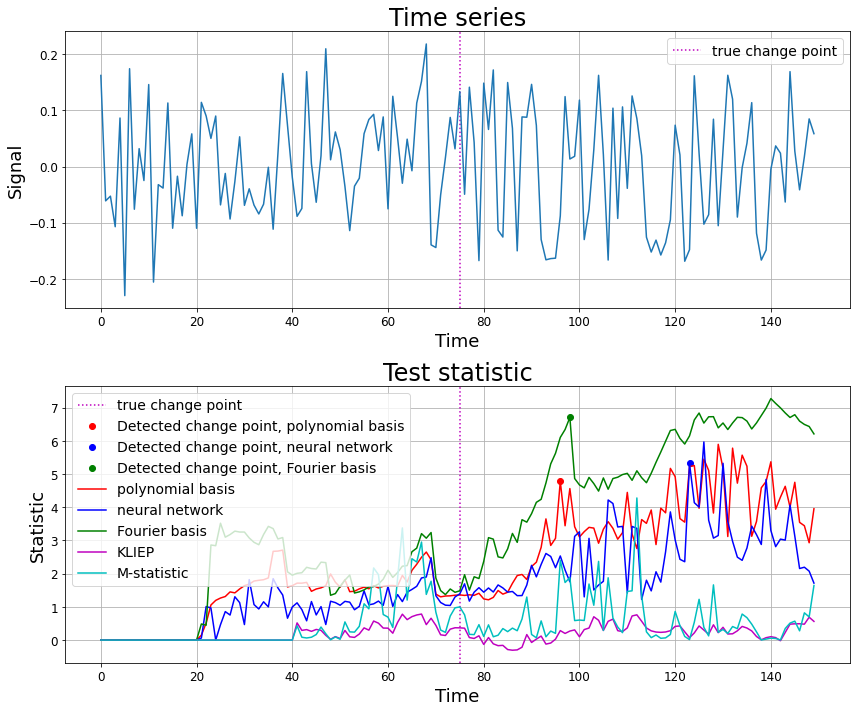

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.axvline(tau, c='m', ls=':', label='true change point')
plt.plot(X)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title(label='Time series', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.subplot(2, 1, 2)
# plt.plot([tau], S_lin[tau], 'x',c='m', label='True change point')
#plt.axhline(y=threshold_nn, xmin=0, xmax=70, ls='--', c='r',label='theshold')
plt.title(label='Test statistic', fontsize=24)
imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_6_poly))
imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_p_6_f))
#imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep))
#imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd))

plt.axvline(tau, c='m', ls=':', label='true change point')

plt.plot([imin_lin], S_lin[imin_lin], 'o', c='r', label='Detected change point, polynomial basis')
plt.plot([imin_nn], S_nn[imin_nn], 'o', c='b', label='Detected change point, neural network')
plt.plot([imin_f], S_f[imin_f], 'o', c='g', label='Detected change point, Fourier basis')
#plt.plot([imin_kliep], S_kliep[imin_kliep], 'o', c='m', label='Detected change point, KLIEP')
#plt.plot([imin_mmd], S_mmd[imin_mmd], 'o', c='c', label='Detected change point, M-statistic')
    
plt.plot(np.arange(n), S_lin, 'r-', label='polynomial basis')
plt.plot(np.arange(n), S_nn, 'b-', label='neural network')
plt.plot(np.arange(n), S_f, 'g-', label='Fourier basis')
plt.plot(np.arange(n), S_kliep, 'm-', label='KLIEP')
plt.plot(np.arange(n), S_mmd, 'c-', label='M-statistic')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Statistic', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('images/dataset3.png')

In [ ]:
np.random.seed(1)

# Number of observations
n = 150
# True change point
tau = 75

# Standard deviation before the change point
sigma = 0.1
# Standard deviation after the change point

p = 6
S_poly_list = []
S_nn_list = []
S_f_list = []

for item in range(10):

    ### Gaussian N(0, sigma^2)
    Z = sigma * randn(n - tau)

    ## Uniform on [-sigma sqrt(3), sigma sqrt(3)]
    Y = 2 * np.sqrt(3) * sigma * (np.random.rand(tau) - 0.5)

    # Sequence of observations
    X = np.append(Y, Z)

    S_poly = compute_test_stat_linear(X, p)
    S_nn = compute_test_stat_nn(X, n_epochs=50)
    S_f = compute_test_stat_fourier(X, p)

    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)
    S_f_list.append(S_f)
    print(item)

0
1
2
3
4
5
6
7
8
9


In [ ]:
S_nn_np = np.array(S_nn_list)
df_nn = pd.DataFrame(S_nn_np.T, columns=range(10))
df_nn.to_csv('DD/dataset_3_nn.csv',index=False)

In [ ]:
S_poly_np = np.array(S_poly_list)
df_poly = pd.DataFrame(S_poly_np.T, columns=range(10))
df_poly.to_csv('DD/dataset_3_poly.csv',index=False)

In [ ]:
S_f_np = np.array(S_f_list)
df_f = pd.DataFrame(S_f_np.T, columns=range(10))
df_f.to_csv('DD/dataset_3_f.csv',index=False)

In [ ]:
threshold_p_6_poly = 3.9617
threshold_p_6_f = 6.4894
threshold_nn = 3.3494

In [ ]:
S_f_list = pd.read_csv('DD/dataset_3_f.csv').T.to_numpy()
S_nn_list = pd.read_csv('DD/dataset_3_nn.csv').T.to_numpy()
S_poly_list = pd.read_csv('DD/dataset_3_poly.csv').T.to_numpy()

In [ ]:
n = 150

In [ ]:
t_lin = []
t_nn = []
t_f= []
for i in range(10):
    print(i)

    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    S_f = S_f_list[i]
    
    if np.sum(S_lin > threshold_p_6_poly) > 0:
        imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_6_poly))
    else:
        imin_lin = n
        
    if np.sum(S_nn > threshold_nn) > 0:
        imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
    else:
        imin_nn = n
    
    if np.sum(S_f > threshold_p_6_f) > 0:
        imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_p_6_f))
    else:
        imin_f = n
    
    # imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_6_poly))
    # imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
    # imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_p_6_f))

    t_lin.append(imin_lin - tau)
    t_nn.append(imin_nn - tau)
    t_f.append(imin_f - tau)

0
1
2
3
4
5
6
7
8
9


In [ ]:
t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np[t_lin_np>=0].mean(), 1)
std_DD_poly = np.round(t_lin_np[t_lin_np>=0].std(), 1)
print('polynomial basis', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np[t_nn_np>=0].mean(), 1)
std_DD_nn = np.round(t_nn_np[t_nn_np>=0].std(), 1)
print('neural network', DD_nn, '±', std_DD_nn)

t_f_np = np.array(t_f)
DD_f = np.round(t_f_np[t_f_np>=0].mean(), 1)
std_DD_f = np.round(t_f_np[t_f_np>=0].std(), 1)
print('Fourier basis', DD_f, '±', std_DD_f)

polynomial basis 89.4 ± 24.4
neural network 79.5 ± 35.9
Fourier basis 96.9 ± 20.2


In [ ]:
t_kliep = []
t_mmd = []

for i in range(10):

    S_kliep = S_kliep_list[i]
    S_mmd = S_mmd_list[i]
    
    if np.sum(S_kliep > threshold_kliep_20) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_50))
    else:
        imin_kliep = n
    
    if np.sum(S_mmd > threshold_mmd_15) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_50))
    else:
        imin_mmd = n
    
    t_kliep.append(imin_kliep - tau)
    t_mmd.append(imin_mmd - tau)

In [ ]:
S_kliep_np = np.array(S_kliep_list)
df_kliep = pd.DataFrame(S_kliep_np.T, columns=range(10))
df_kliep.to_csv('DD/dataset_3_kleip.csv',index=False)

In [ ]:
S_mmd_np = np.array(S_mmd_list)
df_mmd = pd.DataFrame(S_mmd_np.T, columns=range(10))
df_mmd.to_csv('DD/dataset_3_mmd.csv',index=False)

### CENSREC-1-C dataset, MAH_clean

In [ ]:
from scipy.io.wavfile import read
from sklearn.preprocessing import MinMaxScaler

input_data = read("MAH_clean.wav")
audio = input_data[1]

scaler = MinMaxScaler(feature_range=(-1, 1))
audio_sc = scaler.fit_transform(audio.reshape(-1, 1))
audio_sc = audio_sc.reshape(audio_sc.shape[0])

audio_1 = audio_sc[3500:4500][0::10]

In [ ]:
audio_1[:43].std()

0.00019782306397512754

In [ ]:
audio_1 = audio_sc[3500:4500][0::10]
tau_1 = 43
audio_2 = audio_sc[28000:29000][0::10]
tau_2 = 37
audio_3 = audio_sc[61000:62000][::10]
tau_3 = 55
audio_4 = audio_sc[78500:79500][::10]
tau_4 = 44
audio_5 = audio_sc[103000:104000][::10]
tau_5 = 60

audios = [audio_1, audio_2, audio_3, audio_4, audio_5]
taus = [tau_1, tau_2, tau_3, tau_4, tau_5]

In [ ]:
p = 10
S_poly_list = []
S_nn_list = []
S_f_list = []

for item in range(5):
    X = audios[item]

    S_poly = compute_test_stat_linear(X, p)
    S_nn = compute_test_stat_nn(X, n_epochs=200)
    S_f = compute_test_stat_fourier(X, p)

    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)
    S_f_list.append(S_f)

S_nn_np = np.array(S_nn_list)
df_nn = pd.DataFrame(S_nn_np.T, columns=range(5))
df_nn.to_csv('DD/MAH_clean_nn.csv',index=False)
S_f_np = np.array(S_f_list)
df_f = pd.DataFrame(S_f_np.T, columns=range(5))
df_f.to_csv('DD/MAH_clean_f.csv',index=False)
S_poly_np = np.array(S_poly_list)
df_poly = pd.DataFrame(S_poly_np.T, columns=range(5))
df_poly.to_csv('DD/MAH_clean_poly.csv',index=False)

In [ ]:
S_poly_list = pd.read_csv('DD/MAH_clean_poly.csv').T.to_numpy()
S_nn_list = pd.read_csv('DD/MAH_clean_nn.csv').T.to_numpy()
S_f_list = pd.read_csv('DD/MAH_clean_f.csv').T.to_numpy()

In [ ]:
poly_max = []
nn_max = []
f_max = []

for item in range(5):
    S_poly = S_poly_list[item]
    S_nn = S_nn_list[item]
    S_f = S_f_list[item]

    poly_max += [np.max(S_poly[:taus[item]])]
    nn_max += [np.max(S_nn[:taus[item]])]
    f_max += [np.max(S_f[:taus[item]])]

In [ ]:
threshold_poly_1 = np.sort(poly_max)[-2] 
threshold_nn_1 = np.sort(nn_max)[-2] 
threshold_f_1 = np.sort(f_max)[-2]

In [ ]:
threshold_poly_1, threshold_nn_1, threshold_f_1

(1.1760172083672686, 0.8328027768559123, 10.825921715115664)

In [ ]:
t_lin = []
t_nn = []
t_f= []
for i in [0, 1, 2, 3, 4]:
    tau = taus[i]
    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    S_f = S_f_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_poly_1))
    imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn_1))
    imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_f_1))

    t_lin.append(imin_lin - tau)
    t_nn.append(imin_nn - tau)
    t_f.append(imin_f - tau)


t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np[t_lin_np>=0].mean(), 1)
std_DD_poly = np.round(t_lin_np[t_lin_np>=0].std(), 1)
print('polynomial basis', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np[t_nn_np>=0].mean(), 1)
std_DD_nn = np.round(t_nn_np[t_nn_np>=0].std(), 1)
print('neural network', DD_nn, '±', std_DD_nn)

t_f_np = np.array(t_f)
DD_f = np.round(t_f_np[t_f_np>=0].mean(), 1)
std_DD_f = np.round(t_f_np[t_f_np>=0].std(), 1)
print('Fourier basis', DD_f, '±', std_DD_f)

polynomial basis 3.2 ± 4.0
neural network 7.5 ± 6.8
Fourier basis 8.2 ± 6.2


In [ ]:
S_kliep_list= []
S_mmd_list = []

kliep_max = []
mmd_max = []

for item in range(5):
    X = audios[item]

    S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.13)
    S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.04)
    
    kliep_max += [np.max(S_kliep[:taus[item]])]
    mmd_max += [np.max(S_mmd[:taus[item]])]
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)

threshold_kliep_1 = np.sort(kliep_max)[-2]
threshold_mmd_1 = np.sort(mmd_max)[-2] 

t_kliep = []
t_mmd = []

for i in range(5):
    tau = taus[i]

    S_kliep = S_kliep_list[i]
    S_mmd = S_mmd_list[i]
    
    if np.sum(S_kliep > threshold_kliep_1) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_1))
    else:
        imin_kliep = n
    
    if np.sum(S_mmd > threshold_mmd_1) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_1))
    else:
        imin_mmd = n
    
    t_kliep.append(imin_kliep - tau)
    t_mmd.append(imin_mmd - tau)

t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np[t_kliep_np>=0].mean(), 1)
std_DD_kliep = np.round(t_kliep_np[t_kliep_np>=0].std(), 1)
print('Kliep', DD_kliep, '±', std_DD_kliep)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np[t_mmd_np>=0].mean(), 1)
std_DD_mmd = np.round(t_mmd_np[t_mmd_np>=0].std(), 1)
print('M_stat', DD_mmd, '±', std_DD_mmd)

Kliep 7.8 ± 9.7
M_stat 3.2 ± 3.1


In [ ]:
threshold_kliep_1, threshold_mmd_1

(0.036250450888203306, 1.204798839205519)

In [ ]:
S_kliep_np = np.array(S_kliep_list)
df_kliep = pd.DataFrame(S_kliep_np.T, columns=range(5))
df_kliep.to_csv('DD/MAH_clean_kliep.csv',index=False)
S_mmd_np = np.array(S_mmd_list)
df_mmd = pd.DataFrame(S_mmd_np.T, columns=range(5))
df_mmd.to_csv('DD/MAH_clean_mmd.csv',index=False)

In [ ]:
X = audio_1
tau = 43
n = 100

In [ ]:
S_lin = S_poly_list[0]
S_nn = S_nn_list[0]
S_f = S_f_list[0]
S_kliep = S_kliep_list[0]
S_mmd = S_mmd_list[0]

In [ ]:
S_mmd /= 4
threshold_mmd_1 /= 4

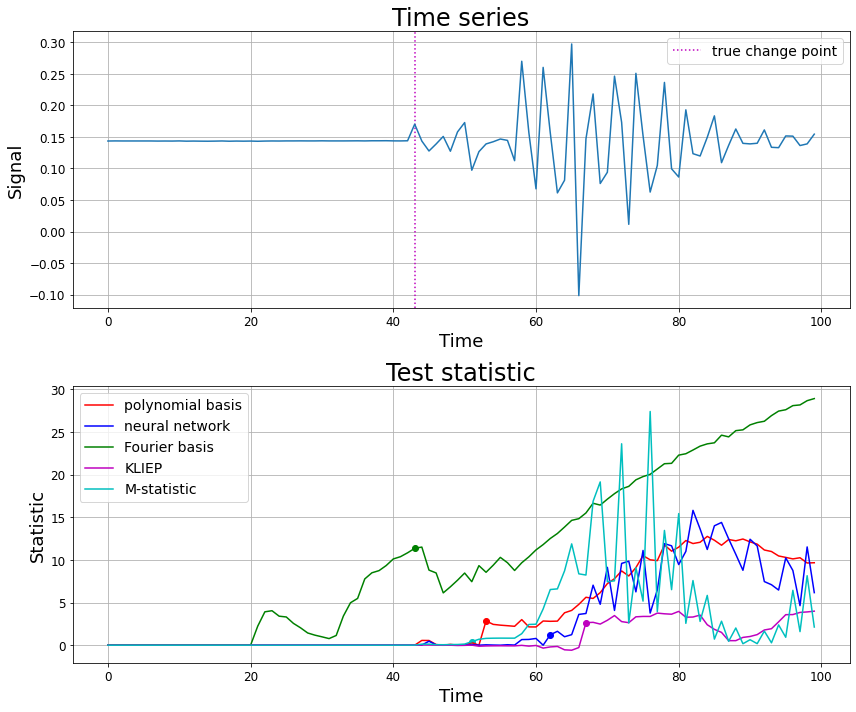

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.axvline(tau, c='m', ls=':', label='true change point')
plt.plot(X)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title(label='Time series', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.subplot(2, 1, 2)
# plt.plot([tau], S_lin[tau], 'x',c='m', label='True change point')
#plt.axhline(y=threshold_nn, xmin=0, xmax=70, ls='--', c='r',label='theshold')
plt.title(label='Test statistic', fontsize=24)
imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_poly_1))
imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn_1))
imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_f_1))
imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_1))
imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_1))

# plt.axvline(tau, c='m', ls=':', label='true change point')

plt.plot([imin_lin], S_lin[imin_lin], 'o', c='r')
plt.plot([imin_nn], S_nn[imin_nn], 'o', c='b')
plt.plot([imin_f], S_f[imin_f], 'o', c='g')
plt.plot([imin_kliep], S_kliep[imin_kliep], 'o', c='m')
plt.plot([imin_mmd], S_mmd[imin_mmd], 'o', c='c')
    
plt.plot(np.arange(n), S_lin, 'r-', label='polynomial basis')
plt.plot(np.arange(n), S_nn, 'b-', label='neural network')
plt.plot(np.arange(n), S_f, 'g-', label='Fourier basis')
plt.plot(np.arange(n), S_kliep, 'm-', label='KLIEP')
plt.plot(np.arange(n), S_mmd, 'c-', label='M-statistic')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Statistic', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('images/MAH_clean.png')

### CENSREC-1-C dataset, MAH_N1_SNR20

In [ ]:
input_data = read("MAH_N1_SNR20.wav")
audio = input_data[1]

scaler = MinMaxScaler(feature_range=(-1, 1))
audio_sc = scaler.fit_transform(audio.reshape(-1, 1))
audio_sc = audio_sc.reshape(audio_sc.shape[0])

audio_1 = audio_sc[3500:4500][0::10]

In [ ]:
audio_1 = audio_sc[3500:4500][0::10]
tau_1 = 43
audio_2 = audio_sc[28000:29000][0::10]
tau_2 = 37
audio_3 = audio_sc[61000:62000][::10]
tau_3 = 55
audio_4 = audio_sc[78500:79500][::10]
tau_4 = 44
audio_5 = audio_sc[103000:104000][::10]
tau_5 = 60

audios = [audio_1, audio_2, audio_3, audio_4, audio_5]
taus = [tau_1, tau_2, tau_3, tau_4, tau_5]

In [ ]:
p = 10
S_poly_list = []
S_nn_list = []
S_f_list = []

for item in range(5):
    X = audios[item]

    S_poly = compute_test_stat_linear(X, p)
    S_nn = compute_test_stat_nn(X, n_epochs=200)
    S_f = compute_test_stat_fourier(X, p)

    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)
    S_f_list.append(S_f)

S_nn_np = np.array(S_nn_list)
df_nn = pd.DataFrame(S_nn_np.T, columns=range(5))
df_nn.to_csv('DD/MAH_N1_SNR20_nn.csv',index=False)
S_f_np = np.array(S_f_list)
df_f = pd.DataFrame(S_f_np.T, columns=range(5))
df_f.to_csv('DD/MAH_N1_SNR20_f.csv',index=False)
S_poly_np = np.array(S_poly_list)
df_poly = pd.DataFrame(S_poly_np.T, columns=range(5))
df_poly.to_csv('DD/MAH_N1_SNR20_poly.csv',index=False)

In [ ]:
S_poly_list = pd.read_csv('DD/MAH_N1_SNR20_poly.csv').T.to_numpy()
S_nn_list = pd.read_csv('DD/MAH_N1_SNR20_nn.csv').T.to_numpy()
S_f_list = pd.read_csv('DD/MAH_N1_SNR20_f.csv').T.to_numpy()

In [ ]:
poly_max = []
nn_max = []
f_max = []

for item in range(5):
    S_poly = S_poly_list[item]
    S_nn = S_nn_list[item]
    S_f = S_f_list[item]

    poly_max += [np.max(S_poly[:taus[item]])]
    nn_max += [np.max(S_nn[:taus[item]])]
    f_max += [np.max(S_f[:taus[item]])]

threshold_poly_2 = np.sort(poly_max)[-2] 
threshold_nn_2 = np.sort(nn_max)[-2] 
threshold_f_2 = np.sort(f_max)[-2]

t_lin = []
t_nn = []
t_f= []
for i in [0, 1, 2, 3, 4]:
    tau = taus[i]
    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    S_f = S_f_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_poly_2))
    imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn_2))
    imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_f_2))

    t_lin.append(imin_lin - tau)
    t_nn.append(imin_nn - tau)
    t_f.append(imin_f - tau)


t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np[t_lin_np>=0].mean(), 1)
std_DD_poly = np.round(t_lin_np[t_lin_np>=0].std(), 1)
print('polynomial basis', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np[t_nn_np>=0].mean(), 1)
std_DD_nn = np.round(t_nn_np[t_nn_np>=0].std(), 1)
print('neural network', DD_nn, '±', std_DD_nn)

t_f_np = np.array(t_f)
DD_f = np.round(t_f_np[t_f_np>=0].mean(), 1)
std_DD_f = np.round(t_f_np[t_f_np>=0].std(), 1)
print('Fourier basis', DD_f, '±', std_DD_f)

polynomial basis 3.8 ± 2.6
neural network 3.0 ± 1.2
Fourier basis 8.2 ± 2.2


In [ ]:
threshold_poly_2, threshold_nn_2, threshold_f_2

(1.7457901966368887, 1.8021022338847783, 5.267743762238179)

In [ ]:
S_kliep_list= []
S_mmd_list = []

kliep_max = []
mmd_max = []

for item in range(5):
    X = audios[item]

    S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.19)
    S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.15)
    
    kliep_max += [np.max(S_kliep[:taus[item]])]
    mmd_max += [np.max(S_mmd[:taus[item]])]
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)

threshold_kliep_2 = np.sort(kliep_max)[-2]
threshold_mmd_2 = np.sort(mmd_max)[-2] 

t_kliep = []
t_mmd = []

for i in range(5):
    tau = taus[i]

    S_kliep = S_kliep_list[i]
    S_mmd = S_mmd_list[i]
    
    if np.sum(S_kliep > threshold_kliep_2) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_2))
    else:
        imin_kliep = n
    
    if np.sum(S_mmd > threshold_mmd_2) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_2))
    else:
        imin_mmd = n
    
    t_kliep.append(imin_kliep - tau)
    t_mmd.append(imin_mmd - tau)

t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np[t_kliep_np>=0].mean(), 1)
std_DD_kliep = np.round(t_kliep_np[t_kliep_np>=0].std(), 1)
print('Kliep', DD_kliep, '±', std_DD_kliep)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np[t_mmd_np>=0].mean(), 1)
std_DD_mmd = np.round(t_mmd_np[t_mmd_np>=0].std(), 1)
print('M_stat', DD_mmd, '±', std_DD_mmd)

Kliep 17.0 ± 13.7
M_stat 10.5 ± 7.9


In [ ]:
S_kliep_np = np.array(S_kliep_list)
df_kliep = pd.DataFrame(S_kliep_np.T, columns=range(5))
df_kliep.to_csv('DD/MAH_SNR20_kliep.csv',index=False)
S_mmd_np = np.array(S_mmd_list)
df_mmd = pd.DataFrame(S_mmd_np.T, columns=range(5))
df_mmd.to_csv('DD/MAH_SNR20_mmd.csv',index=False)

In [ ]:
threshold_kliep_2, threshold_mmd_2

(0.3237124592950408, 2.3401967962945536)

In [ ]:
S_lin = S_poly_list[0]
S_nn = S_nn_list[0]
S_f = S_f_list[0]
S_kliep = S_kliep_list[0]
S_mmd = S_mmd_list[0]

In [ ]:
S_mmd /= 4
threshold_mmd_2 /= 4

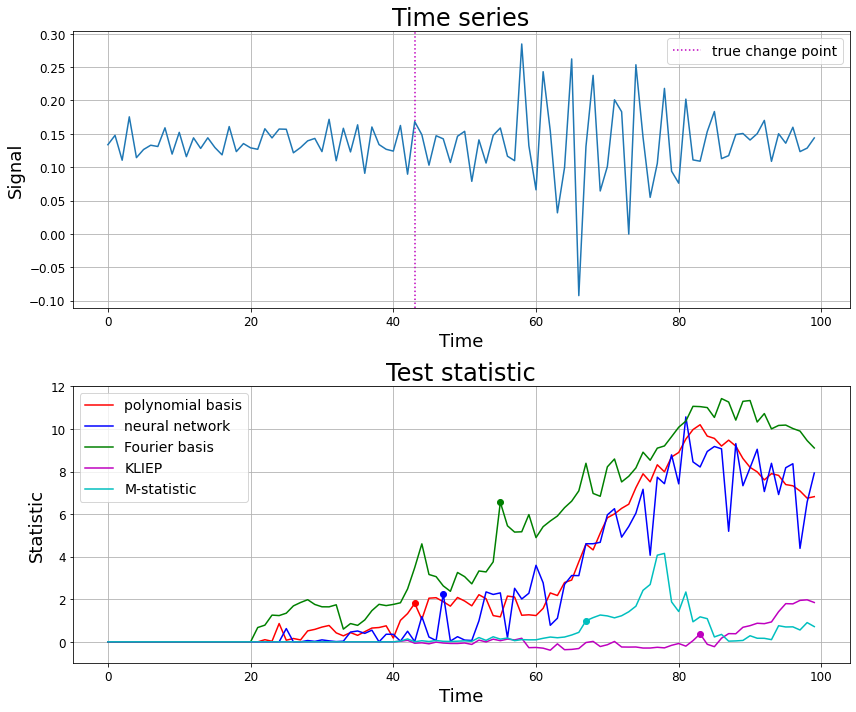

In [ ]:
X = audio_1
tau = 43
n = 100

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.axvline(tau, c='m', ls=':', label='true change point')
plt.plot(X)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title(label='Time series', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.subplot(2, 1, 2)
# plt.plot([tau], S_lin[tau], 'x',c='m', label='True change point')
#plt.axhline(y=threshold_nn, xmin=0, xmax=70, ls='--', c='r',label='theshold')
plt.title(label='Test statistic', fontsize=24)
imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_poly_2))
imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn_2))
imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_f_2))
imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_2))
imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_2))

# plt.axvline(tau, c='m', ls=':', label='true change point')


plt.plot([imin_lin], S_lin[imin_lin], 'o', c='r')
plt.plot([imin_nn], S_nn[imin_nn], 'o', c='b')
plt.plot([imin_f], S_f[imin_f], 'o', c='g')
plt.plot([imin_kliep], S_kliep[imin_kliep], 'o', c='m')
plt.plot([imin_mmd], S_mmd[imin_mmd], 'o', c='c')


plt.plot(np.arange(n), S_lin, 'r-', label='polynomial basis')
plt.plot(np.arange(n), S_nn, 'b-', label='neural network')
plt.plot(np.arange(n), S_f, 'g-', label='Fourier basis')
plt.plot(np.arange(n), S_kliep, 'm-', label='KLIEP')
plt.plot(np.arange(n), S_mmd, 'c-', label='M-statistic')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Statistic', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('images/MAH_N1_SNR20.png')

### CENSREC-1-C dataset, MAH_N1_SNR15

In [ ]:
input_data = read("MAH_N1_SNR15.wav")
audio = input_data[1]

scaler = MinMaxScaler(feature_range=(-1, 1))
audio_sc = scaler.fit_transform(audio.reshape(-1, 1))
audio_sc = audio_sc.reshape(audio_sc.shape[0])

audio_1 = audio_sc[3500:4500][0::10]

In [ ]:
audio_1 = audio_sc[3500:4500][0::10]
tau_1 = 43
audio_2 = audio_sc[28000:29000][0::10]
tau_2 = 37
audio_3 = audio_sc[61000:62000][::10]
tau_3 = 55
audio_4 = audio_sc[78500:79500][::10]
tau_4 = 44
audio_5 = audio_sc[103000:104000][::10]
tau_5 = 60

audios = [audio_1, audio_2, audio_3, audio_4, audio_5]
taus = [tau_1, tau_2, tau_3, tau_4, tau_5]

In [ ]:
p = 10
S_poly_list = []
S_nn_list = []
S_f_list = []

for item in range(5):
    X = audios[item]

    S_poly = compute_test_stat_linear(X, p)
    S_nn = compute_test_stat_nn(X, n_epochs=200)
    S_f = compute_test_stat_fourier(X, p)

    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)
    S_f_list.append(S_f)

S_nn_np = np.array(S_nn_list)
df_nn = pd.DataFrame(S_nn_np.T, columns=range(5))
df_nn.to_csv('DD/MAH_N1_SNR15_nn.csv',index=False)
S_f_np = np.array(S_f_list)
df_f = pd.DataFrame(S_f_np.T, columns=range(5))
df_f.to_csv('DD/MAH_N1_SNR15.csv',index=False)
S_poly_np = np.array(S_poly_list)
df_poly = pd.DataFrame(S_poly_np.T, columns=range(5))
df_poly.to_csv('DD/MAH_N1_SNR15_poly.csv',index=False)

In [ ]:
p = 10
S_poly_list = []

for item in range(5):
    X = audios[item]

    S_poly = compute_test_stat_linear(X, p)

    S_poly_list.append(S_poly)
    print(item)

0
1
2
3
4


In [ ]:
# S_poly_list = pd.read_csv('DD/MAH_N1_SNR15_poly.csv').T.to_numpy()
S_nn_list = pd.read_csv('DD/MAH_N1_SNR15_nn.csv').T.to_numpy()
S_f_list = pd.read_csv('DD/MAH_N1_SNR15_f.csv').T.to_numpy()

In [ ]:
poly_max = []
nn_max = []
f_max = []

for item in range(5):
    S_poly = S_poly_list[item]
    S_nn = S_nn_list[item]
    S_f = S_f_list[item]

    poly_max += [np.max(S_poly[:taus[item]])]
    nn_max += [np.max(S_nn[:taus[item]])]
    f_max += [np.max(S_f[:taus[item]])]

threshold_poly_3 = np.sort(poly_max)[-2] 
threshold_nn_3 = np.sort(nn_max)[-2] 
threshold_f_3 = np.sort(f_max)[-2]

t_lin = []
t_nn = []
t_f= []
for i in [0, 1, 2, 3, 4]:
    tau = taus[i]
    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    S_f = S_f_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_poly_3))
    imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn_3))
    imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_f_3))

    t_lin.append(imin_lin - tau)
    t_nn.append(imin_nn - tau)
    t_f.append(imin_f - tau)


t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np[t_lin_np>=0].mean(), 1)
std_DD_poly = np.round(t_lin_np[t_lin_np>=0].std(), 1)
print('polynomial basis', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np[t_nn_np>=0].mean(), 1)
std_DD_nn = np.round(t_nn_np[t_nn_np>=0].std(), 1)
print('neural network', DD_nn, '±', std_DD_nn)

t_f_np = np.array(t_f)
DD_f = np.round(t_f_np[t_f_np>=0].mean(), 1)
std_DD_f = np.round(t_f_np[t_f_np>=0].std(), 1)
print('Fourier basis', DD_f, '±', std_DD_f)

polynomial basis 6.5 ± 7.8
neural network 9.0 ± 5.9
Fourier basis 11.0 ± 6.9


In [ ]:
S_kliep_list= []
S_mmd_list = []

kliep_max = []
mmd_max = []

for item in range(5):
    X = audios[item]

    S_kliep = compute_test_stat_kliep(X, window_size=20, sigma=0.2)
    S_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.1)
    
    kliep_max += [np.max(S_kliep[:taus[item]])]
    mmd_max += [np.max(S_mmd[:taus[item]])]
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)

threshold_kliep_3 = np.sort(kliep_max)[-2]
threshold_mmd_3 = np.sort(mmd_max)[-2] 

t_kliep = []
t_mmd = []

for i in range(5):
    tau = taus[i]

    S_kliep = S_kliep_list[i]
    S_mmd = S_mmd_list[i]
    
    if np.sum(S_kliep > threshold_kliep_3) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_3))
    else:
        imin_kliep = n
    
    if np.sum(S_mmd > threshold_mmd_3) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_3))
    else:
        imin_mmd = n
    
    t_kliep.append(imin_kliep - tau)
    t_mmd.append(imin_mmd - tau)

t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np[t_kliep_np>=0].mean(), 1)
std_DD_kliep = np.round(t_kliep_np[t_kliep_np>=0].std(), 1)
print('Kliep', DD_kliep, '±', std_DD_kliep)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np[t_mmd_np>=0].mean(), 1)
std_DD_mmd = np.round(t_mmd_np[t_mmd_np>=0].std(), 1)
print('M_stat', DD_mmd, '±', std_DD_mmd)

Kliep 10.2 ± 8.8
M_stat 4.2 ± 4.3


In [ ]:
S_kliep_np = np.array(S_kliep_list)
df_kliep = pd.DataFrame(S_kliep_np.T, columns=range(5))
df_kliep.to_csv('DD/MAH_SNR15_kliep.csv',index=False)
S_mmd_np = np.array(S_mmd_list)
df_mmd = pd.DataFrame(S_mmd_np.T, columns=range(5))
df_mmd.to_csv('DD/MAH_SNR15_mmd.csv',index=False)

In [ ]:
threshold_kliep_3, threshold_mmd_3

(0.12134102633866088, 0.8598547258632309)

In [ ]:
S_lin = S_poly_list[0]
S_nn = S_nn_list[0]
S_f = S_f_list[0]
S_kliep = S_kliep_list[0]
S_mmd = S_mmd_list[0]

S_mmd /= 4
threshold_mmd_3 /= 4

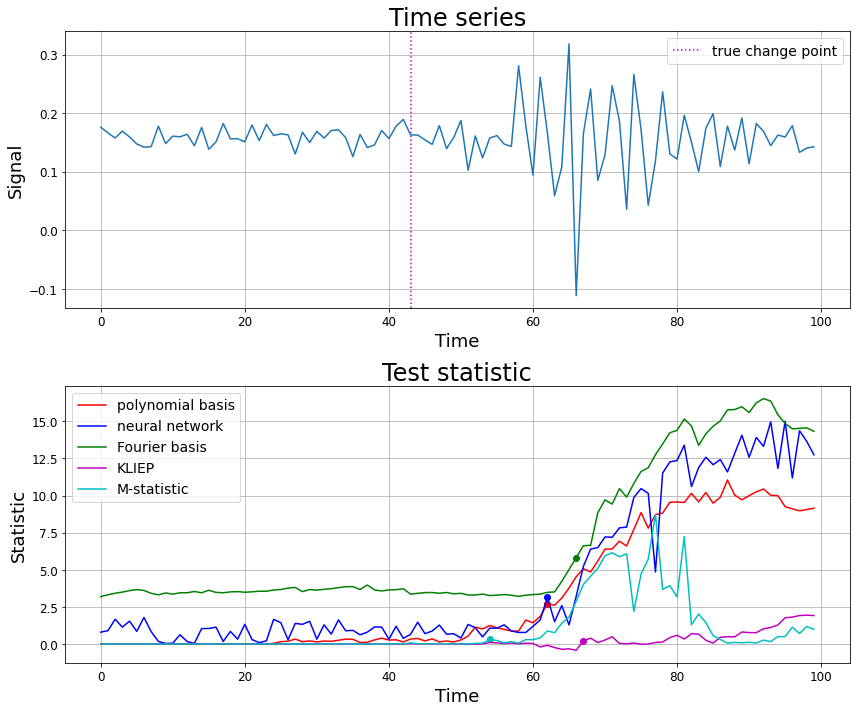

In [ ]:
X = audio_1
tau = 43
n = 100

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.axvline(tau, c='m', ls=':', label='true change point')
plt.plot(X)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title(label='Time series', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.subplot(2, 1, 2)
# plt.plot([tau], S_lin[tau], 'x',c='m', label='True change point')
#plt.axhline(y=threshold_nn, xmin=0, xmax=70, ls='--', c='r',label='theshold')
plt.title(label='Test statistic', fontsize=24)
imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_poly_3))
imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn_3))
imin_f, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_f, S_f <= threshold_f_3))
imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep_3))
imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd_3))

# plt.axvline(tau, c='m', ls=':', label='true change point')

'''
plt.plot([imin_lin], S_lin[imin_lin], 'o', c='r', label='Detected change point, polynomial basis')
plt.plot([imin_nn], S_nn[imin_nn], 'o', c='b', label='Detected change point, neural network')
plt.plot([imin_f], S_f[imin_f], 'o', c='g', label='Detected change point, Fourier basis')
plt.plot([imin_kliep], S_kliep[imin_kliep], 'o', c='m', label='Detected change point, KLIEP')
plt.plot([imin_mmd], S_mmd[imin_mmd], 'o', c='c', label='Detected change point, M-statistic')
'''

plt.plot([imin_lin], S_lin[imin_lin], 'o', c='r')
plt.plot([imin_nn], S_nn[imin_nn], 'o', c='b')
plt.plot([imin_f], S_f[imin_f], 'o', c='g')
plt.plot([imin_kliep], S_kliep[imin_kliep], 'o', c='m')
plt.plot([imin_mmd], S_mmd[imin_mmd], 'o', c='c')


plt.plot(np.arange(n), S_lin, 'r-', label='polynomial basis')
plt.plot(np.arange(n), S_nn, 'b-', label='neural network')
plt.plot(np.arange(n), S_f, 'g-', label='Fourier basis')
plt.plot(np.arange(n), S_kliep, 'm-', label='KLIEP')
plt.plot(np.arange(n), S_mmd, 'c-', label='M-statistic')

plt.legend(loc=0, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Statistic', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('images/MAH_N1_SNR15.png')

### WISDM dataset